In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [2]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] =False

# TabNet ÌèêÏóÖÎ•† Î∂ÑÎ•ò ÏòàÏ∏° Î™®Îç∏

**Î™©Ìëú**: ÏÑúÏö∏Ïãú ÏÉÅÍ∂å Îç∞Ïù¥ÌÑ∞Î•º ÌôúÏö©Ìïú ÌèêÏóÖ ÏúÑÌóòÎèÑ Î∂ÑÎ•ò (High Risk / Low Risk)

**ÏÇ¨Ïö©Î™®Îç∏**:
- TabNet (Attention-based Tabular Deep Learning)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. ÎùºÏù¥Î∏åÎü¨Î¶¨ ÏûÑÌè¨Ìä∏ Î∞è GPU ÏÑ§Ï†ï

In [4]:
!pip install optuna pytorch-tabnet imbalanced-learn -q

In [5]:
# ÌïÑÏöî ÎùºÏù¥Î∏åÎü¨Î¶¨ ÏûÑÌè¨Ìä∏
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from pathlib import Path
import pickle
import json
import warnings
warnings.filterwarnings('ignore')

# Sklearn
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    precision_recall_curve, roc_curve, average_precision_score
)
from sklearn.utils.class_weight import compute_class_weight

# SMOTE
from imblearn.over_sampling import SMOTE

# TabNet
from pytorch_tabnet.tab_model import TabNetClassifier



# ÏãúÎìú ÏÑ§Ï†ï
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

print("‚úì ÎùºÏù¥Î∏åÎü¨Î¶¨ ÏûÑÌè¨Ìä∏ ÏôÑÎ£å")

‚úì ÎùºÏù¥Î∏åÎü¨Î¶¨ ÏûÑÌè¨Ìä∏ ÏôÑÎ£å


In [ ]:
# GPU ÏÑ§Ï†ï (Mac GPU ÏûêÎèô Í∞êÏßÄ)
if torch.backends.mps.is_available():
    device = 'mps'
    print("Mac GPU ÏÇ¨Ïö©")
elif torch.cuda.is_available():
    device = 'cuda'
    print("NVIDIA GPU ÏÇ¨Ïö©")
else:
    device = 'cpu'
    print("GPU ÏÇ¨Ïö© Î∂àÍ∞Ä, CPU ÏÇ¨Ïö©")

print(f"Device: {device}")

‚úì NVIDIA GPU ÏÇ¨Ïö©
Device: cuda


## 2. Îç∞Ïù¥ÌÑ∞ Î°úÎìú Î∞è ÌÉêÏÉâ

In [7]:
# Îç∞Ïù¥ÌÑ∞ Î°úÎìú
data_path = '/content/drive/MyDrive/merged_data.csv'
df = pd.read_csv(data_path)

print(f"‚úì Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏôÑÎ£å")
print(f"  - Shape: {df.shape}")
print(f"  - Ìñâ Ïàò: {len(df):,}")
print(f"  - Ïª¨Îüº Ïàò: {len(df.columns)}")

‚úì Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏôÑÎ£å
  - Shape: (39975, 137)
  - Ìñâ Ïàò: 39,975
  - Ïª¨Îüº Ïàò: 137


In [8]:
# Îç∞Ïù¥ÌÑ∞ ÎØ∏Î¶¨Î≥¥Í∏∞
print("\n[Îç∞Ïù¥ÌÑ∞ ÎØ∏Î¶¨Î≥¥Í∏∞]")
df.head()


[Îç∞Ïù¥ÌÑ∞ ÎØ∏Î¶¨Î≥¥Í∏∞]


Í∏∞Ï§Ä_ÎÖÑÎ∂ÑÍ∏∞_ÏΩîÎìú ÏûêÏπòÍµ¨_ÏΩîÎìú_Î™Ö ÏÑúÎπÑÏä§_ÏóÖÏ¢Ö_ÏΩîÎìú_Î™Ö   Ï†êÌè¨_Ïàò  Ïú†ÏÇ¨_ÏóÖÏ¢Ö_Ï†êÌè¨_Ïàò  Í∞úÏóÖ_Î•†  Í∞úÏóÖ_Ï†êÌè¨_Ïàò  ÌèêÏóÖ_Î•†  \
0      20191      Í∞ïÎÇ®Íµ¨         PCÎ∞©  122.0       132.0   9.8     13.0   6.8   
1      20191      Í∞ïÎÇ®Íµ¨          Í∞ÄÍµ¨  435.0       436.0   2.8     12.0   0.7   
2      20191      Í∞ïÎÇ®Íµ¨          Í∞ÄÎ∞©  279.0       280.0   4.3     12.0   3.6   
3      20191      Í∞ïÎÇ®Íµ¨        Í∞ÄÏ†ÑÏ†úÌíà  163.0       163.0   1.8      3.0   1.2   
4      20191      Í∞ïÎÇ®Íµ¨      Í∞ÄÏ†ÑÏ†úÌíàÏàòÎ¶¨   92.0        92.0   3.3      3.0   1.1   

   ÌèêÏóÖ_Ï†êÌè¨_Ïàò  ÌîÑÎûúÏ∞®Ïù¥Ï¶à_Ï†êÌè¨_Ïàò  ...  ÎÇ®ÏÑ±Ïó∞Î†πÎåÄ_30_ÏßÅÏû•_Ïù∏Íµ¨_Ïàò  ÎÇ®ÏÑ±Ïó∞Î†πÎåÄ_40_ÏßÅÏû•_Ïù∏Íµ¨_Ïàò  \
0      9.0        10.0  ...          178522.0          164466.0   
1      3.0         1.0  ...          178522.0          164466.0   
2     10.0         1.0  ...          178522.0          164466.0   
3      2.0         0.0  ...          178522.0          164466.0   
4      1.0         0.0  ...          178522.0          164466.0   

   ÎÇ®ÏÑ±Ïó∞Î†πÎåÄ_50_ÏßÅÏû•_Ïù∏Íµ¨_Ïàò  ÎÇ®ÏÑ±Ïó∞Î†πÎåÄ_60_Ïù¥ÏÉÅ_ÏßÅÏû•_Ïù∏Íµ¨_Ïàò  Ïó¨ÏÑ±Ïó∞Î†πÎåÄ_10_ÏßÅÏû•_Ïù∏Íµ¨_Ïàò  Ïó¨ÏÑ±Ïó∞Î†πÎåÄ_20_ÏßÅÏû•_Ïù∏Íµ¨_Ïàò  \
0          100728.0              44021.0            1679.0           99408.0   
1          100728.0              44021.0            1679.0           99408.0   
2          100728.0              44021.0            1679.0           99408.0   
3          100728.0              44021.0            1679.0           99408.0   
4          100728.0              44021.0            1679.0           99408.0   

   Ïó¨ÏÑ±Ïó∞Î†πÎåÄ_30_ÏßÅÏû•_Ïù∏Íµ¨_Ïàò  Ïó¨ÏÑ±Ïó∞Î†πÎåÄ_40_ÏßÅÏû•_Ïù∏Íµ¨_Ïàò  Ïó¨ÏÑ±Ïó∞Î†πÎåÄ_50_ÏßÅÏû•_Ïù∏Íµ¨_Ïàò  Ïó¨ÏÑ±Ïó∞Î†πÎåÄ_60_Ïù¥ÏÉÅ_ÏßÅÏû•_Ïù∏Íµ¨_Ïàò  
0          108205.0           74466.0           54523.0              22838.0  
1          108205.0           74466.0           54523.0              22838.0  
2          108205.0           74466.0           54523.0              22838.0  
3          108205.0           74466.0           54523.0              22838.0  
4          108205.0           74466.0           54523.0              22838.0  

[5 rows x 137 columns]


[ÌèêÏóÖÎ•† ÌÜµÍ≥Ñ]
count    39975.000000
mean         2.589829
std          2.001541
min          0.000000
25%          1.200000
50%          2.300000
75%          3.600000
max         33.300000
Name: ÌèêÏóÖ_Î•†, dtype: float64


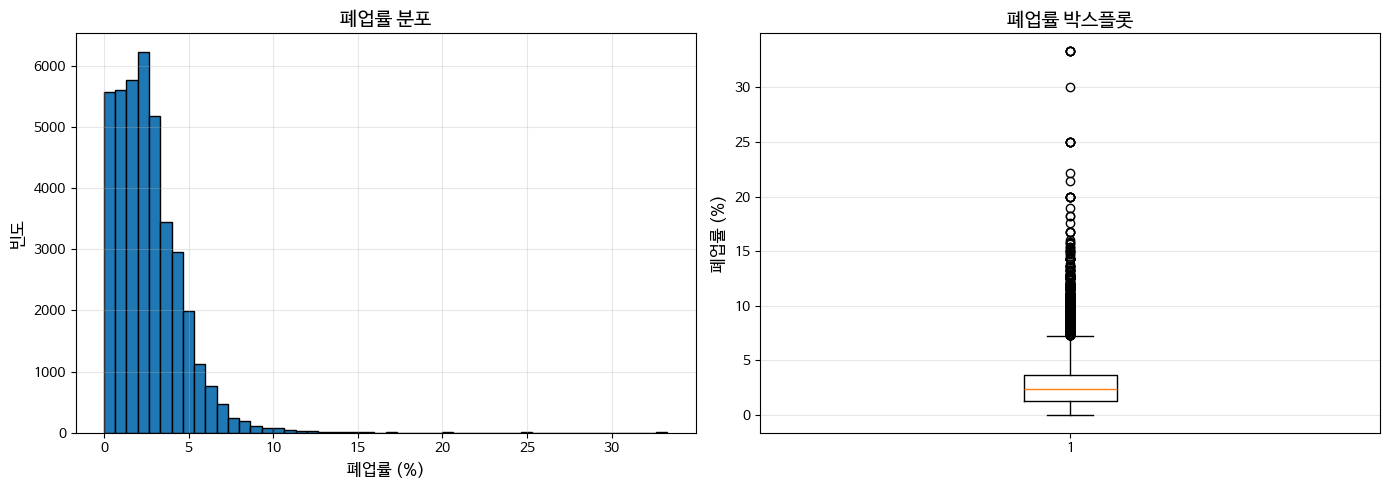

In [9]:
# Í∏∞Î≥∏ ÌÜµÍ≥Ñ
print("\n[ÌèêÏóÖÎ•† ÌÜµÍ≥Ñ]")
print(df['ÌèêÏóÖ_Î•†'].describe())

# ÌèêÏóÖÎ•† Î∂ÑÌè¨ ÏãúÍ∞ÅÌôî
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df['ÌèêÏóÖ_Î•†'], bins=50, edgecolor='black')
axes[0].set_xlabel('ÌèêÏóÖÎ•† (%)', fontsize=12)
axes[0].set_ylabel('ÎπàÎèÑ', fontsize=12)
axes[0].set_title('ÌèêÏóÖÎ•† Î∂ÑÌè¨', fontsize=14)
axes[0].grid(True, alpha=0.3)

axes[1].boxplot(df['ÌèêÏóÖ_Î•†'])
axes[1].set_ylabel('ÌèêÏóÖÎ•† (%)', fontsize=12)
axes[1].set_title('ÌèêÏóÖÎ•† Î∞ïÏä§ÌîåÎ°Ø', fontsize=14)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 3. ÌÉÄÍ≤ü Î≥ÄÏàò ÏÉùÏÑ±

In [10]:
# ÌèêÏóÖÎ•† ÏÉÅÏúÑ 50%Î•º High RiskÎ°ú Î∂ÑÎ•ò
threshold_percentile = 50
threshold = df['ÌèêÏóÖ_Î•†'].quantile(threshold_percentile / 100)

df['closure_risk'] = (df['ÌèêÏóÖ_Î•†'] >= threshold).astype(int)

print(f"‚úì ÌÉÄÍ≤ü Î≥ÄÏàò ÏÉùÏÑ± ÏôÑÎ£å")
print(f"  - ÌèêÏóÖÎ•† ÏûÑÍ≥ÑÍ∞í: {threshold:.2f}%")
print(f"\n‚úì ÌÅ¥ÎûòÏä§ Î∂ÑÌè¨:")
print(df['closure_risk'].value_counts())
print(f"\n‚úì ÌÅ¥ÎûòÏä§ ÎπÑÏú®:")
for cls, count in df['closure_risk'].value_counts().items():
    print(f"  - Class {cls}: {count/len(df)*100:.2f}%")

‚úì ÌÉÄÍ≤ü Î≥ÄÏàò ÏÉùÏÑ± ÏôÑÎ£å
  - ÌèêÏóÖÎ•† ÏûÑÍ≥ÑÍ∞í: 2.30%

‚úì ÌÅ¥ÎûòÏä§ Î∂ÑÌè¨:
closure_risk
1    20320
0    19655
Name: count, dtype: int64

‚úì ÌÅ¥ÎûòÏä§ ÎπÑÏú®:
  - Class 1: 50.83%
  - Class 0: 49.17%


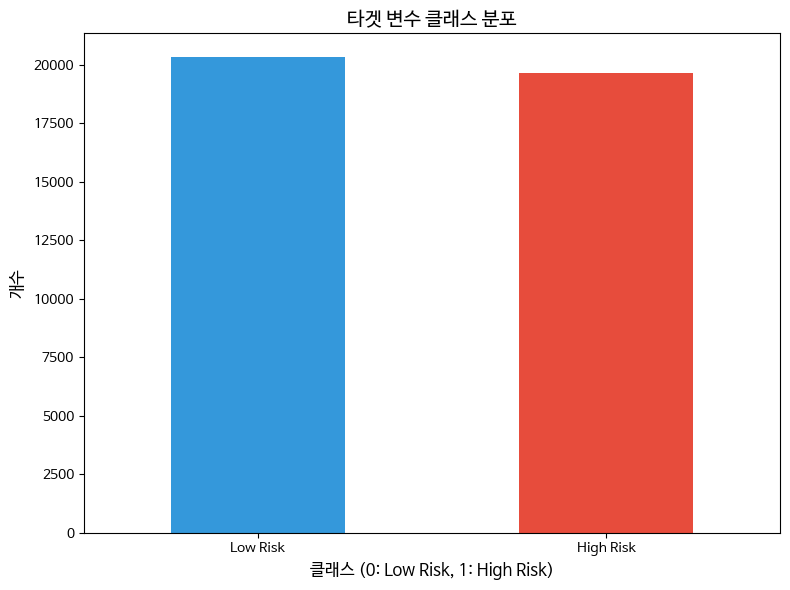

In [11]:
# ÌÅ¥ÎûòÏä§ Î∂ÑÌè¨ ÏãúÍ∞ÅÌôî
fig, ax = plt.subplots(figsize=(8, 6))
df['closure_risk'].value_counts().plot(kind='bar', ax=ax, color=['#3498db', '#e74c3c'])
ax.set_xlabel('ÌÅ¥ÎûòÏä§ (0: Low Risk, 1: High Risk)', fontsize=12)
ax.set_ylabel('Í∞úÏàò', fontsize=12)
ax.set_title('ÌÉÄÍ≤ü Î≥ÄÏàò ÌÅ¥ÎûòÏä§ Î∂ÑÌè¨', fontsize=14)
ax.set_xticklabels(['Low Risk', 'High Risk'], rotation=0)
plt.tight_layout()
plt.show()

## 4. Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨

In [ ]:
# Î≤îÏ£ºÌòï Î≥ÄÏàò Ïù∏ÏΩîÎî©
print("‚úì Î≤îÏ£ºÌòï Î≥ÄÏàò Ïù∏ÏΩîÎî©")

# ÏûêÏπòÍµ¨ Ïù∏ÏΩîÎî©
le_district = LabelEncoder()
df['ÏûêÏπòÍµ¨_encoded'] = le_district.fit_transform(df['ÏûêÏπòÍµ¨_ÏΩîÎìú_Î™Ö'])
print(f"  - ÏûêÏπòÍµ¨: {len(le_district.classes_)}Í∞ú")

# ÏóÖÏ¢Ö Ïù∏ÏΩîÎî©
le_industry = LabelEncoder()
df['ÏóÖÏ¢Ö_encoded'] = le_industry.fit_transform(df['ÏÑúÎπÑÏä§_ÏóÖÏ¢Ö_ÏΩîÎìú_Î™Ö'])
print(f"  - ÏóÖÏ¢Ö: {len(le_industry.classes_)}Í∞ú")

# ÏÉÅÍ∂åÎ≥ÄÌôîÏßÄÌëú Ïù∏ÏΩîÎî©
le_change = LabelEncoder()
df['ÏÉÅÍ∂åÎ≥ÄÌôî_encoded'] = le_change.fit_transform(df['ÏÉÅÍ∂å_Î≥ÄÌôî_ÏßÄÌëú'])
print(f"  - ÏÉÅÍ∂å Î≥ÄÌôî ÏßÄÌëú: {len(le_change.classes_)}Í∞ú")

# Î∂ÑÍ∏∞ Ï†ïÎ≥¥ Ï∂îÏ∂ú
df['year'] = df['Í∏∞Ï§Ä_ÎÖÑÎ∂ÑÍ∏∞_ÏΩîÎìú'].astype(str).str[:4].astype(int)
df['quarter'] = df['Í∏∞Ï§Ä_ÎÖÑÎ∂ÑÍ∏∞_ÏΩîÎìú'].astype(str).str[4:].astype(int)
df['year_quarter'] = df['year'] * 10 + df['quarter']

print(f"  - Î∂ÑÍ∏∞ Î≤îÏúÑ: {df['year_quarter'].min()} ~ {df['year_quarter'].max()}")

# Feature Engineering
print("\n‚úì Feature Engineering")

# ÏãúÍ≥ÑÏó¥ ÏàúÏÑúÎåÄÎ°ú Ï†ïÎ†¨
df = df.sort_values(['ÏûêÏπòÍµ¨_encoded', 'ÏóÖÏ¢Ö_encoded', 'year_quarter'])

# Interaction Features
df['Ï†êÌè¨Îãπ_Îß§Ï∂ú'] = df['ÎãπÏõî_Îß§Ï∂ú_Í∏àÏï°'] / (df['Ï†êÌè¨_Ïàò'] + 1)
df['Í±¥Îãπ_Îß§Ï∂ú'] = df['ÎãπÏõî_Îß§Ï∂ú_Í∏àÏï°'] / (df['ÎãπÏõî_Îß§Ï∂ú_Í±¥Ïàò'] + 1)
df['Ï†êÌè¨Îãπ_Ïú†ÎèôÏù∏Íµ¨'] = df['Ï¥ù_Ïú†ÎèôÏù∏Íµ¨_Ïàò'] / (df['Ï†êÌè¨_Ïàò'] + 1)
# ÏßÄÎÇú Î∂ÑÍ∏∞(lag1)Ïùò Í∞úÏóÖÎ•†, ÌèêÏóÖÎ•† -> Ìï¥Îãπ Î∂ÑÍ∏∞ Ïù¥Ï†Ñ ÌèêÏóÖÎ•† ÌôúÏö©
df['Í∞úÏóÖ_Î•†_lag1'] = df.groupby(['ÏûêÏπòÍµ¨_encoded', 'ÏóÖÏ¢Ö_encoded'])['Í∞úÏóÖ_Î•†'].shift(1)
df['ÌèêÏóÖ_Î•†_lag1'] = df.groupby(['ÏûêÏπòÍµ¨_encoded', 'ÏóÖÏ¢Ö_encoded'])['ÌèêÏóÖ_Î•†'].shift(1)
# ÏßÄÎÇú Î∂ÑÍ∏∞Ïùò Í∞úÌèêÏóÖ ÎπÑÏú®
df['Í∞úÌèêÏóÖ_ÎπÑÏú®_lag1'] = df['Í∞úÏóÖ_Î•†_lag1'] / (df['ÌèêÏóÖ_Î•†_lag1'] + 0.1)

# Ratio Features
df['ÎÇ®ÏÑ±_Îß§Ï∂ú_ÎπÑÏú®'] = df['ÎÇ®ÏÑ±_Îß§Ï∂ú_Í∏àÏï°'] / (df['ÎãπÏõî_Îß§Ï∂ú_Í∏àÏï°'] + 1)
df['Ïó¨ÏÑ±_Îß§Ï∂ú_ÎπÑÏú®'] = df['Ïó¨ÏÑ±_Îß§Ï∂ú_Í∏àÏï°'] / (df['ÎãπÏõî_Îß§Ï∂ú_Í∏àÏï°'] + 1)
df['Ï£ºÎßê_Îß§Ï∂ú_ÎπÑÏú®'] = (df['ÌÜ†ÏöîÏùº_Îß§Ï∂ú_Í∏àÏï°'] + df['ÏùºÏöîÏùº_Îß§Ï∂ú_Í∏àÏï°']) / (df['ÎãπÏõî_Îß§Ï∂ú_Í∏àÏï°'] + 1)
df['ÏïºÍ∞Ñ_Îß§Ï∂ú_ÎπÑÏú®'] = (df['ÏãúÍ∞ÑÎåÄ_00_06_Îß§Ï∂ú_Í∏àÏï°'] + df['ÏãúÍ∞ÑÎåÄ_21_24_Îß§Ï∂ú_Í∏àÏï°']) / (df['ÎãπÏõî_Îß§Ï∂ú_Í∏àÏï°'] + 1)
df['Ïó∞Î†πÎåÄ_20_Îß§Ï∂ú_ÎπÑÏú®'] = df['Ïó∞Î†πÎåÄ_20_Îß§Ï∂ú_Í∏àÏï°'] / (df['ÎãπÏõî_Îß§Ï∂ú_Í∏àÏï°'] + 1)
df['Ïó∞Î†πÎåÄ_30_Îß§Ï∂ú_ÎπÑÏú®'] = df['Ïó∞Î†πÎåÄ_30_Îß§Ï∂ú_Í∏àÏï°'] / (df['ÎãπÏõî_Îß§Ï∂ú_Í∏àÏï°'] + 1)


# Aggregation Features
df['Ï¥ù_Ïù∏Íµ¨'] = df['Ï¥ù_Ïú†ÎèôÏù∏Íµ¨_Ïàò'] + df['Ï¥ù_ÏÉÅÏ£ºÏù∏Íµ¨_Ïàò'] + df['Ï¥ù_ÏßÅÏû•Ïù∏Íµ¨_Ïàò']
df['1Ïù∏Îãπ_ÏÜåÎìù'] = df['Ïõî_ÌèâÍ∑†_ÏÜåÎìù_Í∏àÏï°'] / (df['Ï¥ù_ÏÉÅÏ£ºÏù∏Íµ¨_Ïàò'] + 1)
df['ÏÜåÎìùÏßÄÏ∂úÎπÑÏú®'] = df['Ïõî_ÌèâÍ∑†_ÏÜåÎìù_Í∏àÏï°'] / (df['ÏßÄÏ∂ú_Ï¥ù_Í∏àÏï°'] + 1)
df['Ï†êÌè¨Îãπ_Í∞ÄÍµ¨Ïàò'] = df['Ï¥ù_Í∞ÄÍµ¨_Ïàò'] / (df['Ï†êÌè¨_Ïàò'] + 1)


# Density Features
df['Ïú†ÎèôÏù∏Íµ¨_Î∞ÄÏßëÎèÑ'] = df['Ï¥ù_Ïú†ÎèôÏù∏Íµ¨_Ïàò'] / (df['Ï¥ù_ÏÉÅÏ£ºÏù∏Íµ¨_Ïàò'] + 1)
df['ÏßÅÏû•Ïù∏Íµ¨_ÎπÑÏú®'] = df['Ï¥ù_ÏßÅÏû•Ïù∏Íµ¨_Ïàò'] / (df['Ï¥ù_ÏÉÅÏ£ºÏù∏Íµ¨_Ïàò'] + 1)
df['Ï†êÌè¨_Î∞ÄÏßëÎèÑ'] = df['Ï†êÌè¨_Ïàò'] / (df['Ïú†ÏÇ¨_ÏóÖÏ¢Ö_Ï†êÌè¨_Ïàò'] + 1)


# Competition Features
df['ÌîÑÎûúÏ∞®Ïù¥Ï¶à_ÎπÑÏú®'] = df['ÌîÑÎûúÏ∞®Ïù¥Ï¶à_Ï†êÌè¨_Ïàò'] / (df['Ï†êÌè¨_Ïàò'] + 1)
df['Í≤ΩÏüÅÎèÑ'] = df['Ïú†ÏÇ¨_ÏóÖÏ¢Ö_Ï†êÌè¨_Ïàò'] / (df['Ï†êÌè¨_Ïàò'] + 1)



print(f"  - ÌòÑÏû¨ Ï¥ù Ïª¨Îüº Ïàò: {len(df.columns)}")

‚úì Î≤îÏ£ºÌòï Î≥ÄÏàò Ïù∏ÏΩîÎî©
  - ÏûêÏπòÍµ¨: 25Í∞ú
  - ÏóÖÏ¢Ö: 63Í∞ú
  - ÏÉÅÍ∂å Î≥ÄÌôî ÏßÄÌëú: 4Í∞ú
  - Î∂ÑÍ∏∞ Î≤îÏúÑ: 20191 ~ 20252

‚úì Feature Engineering
  - ÌòÑÏû¨ Ï¥ù Ïª¨Îüº Ïàò: 165


In [13]:
# Feature ÏÑ†ÌÉù
print("\n‚úì Feature ÏÑ†ÌÉù")

# Î≤îÏ£ºÌòï Î≥ÄÏàò (Ïù∏ÏΩîÎî©Îêú Î≤ÑÏ†Ñ ÏÇ¨Ïö©)
categorical_features = ['ÏûêÏπòÍµ¨_encoded', 'ÏóÖÏ¢Ö_encoded', 'ÏÉÅÍ∂åÎ≥ÄÌôî_encoded']

# Ï†úÏô∏Ìï† Ïª¨ÎüºÎì§
exclude_cols = [
    # ÏõêÎ≥∏ Î≤îÏ£ºÌòï Î≥ÄÏàò (Ïù∏ÏΩîÎî© Ï†Ñ)
    'Í∏∞Ï§Ä_ÎÖÑÎ∂ÑÍ∏∞_ÏΩîÎìú', 'ÏûêÏπòÍµ¨_ÏΩîÎìú_Î™Ö', 'ÏÑúÎπÑÏä§_ÏóÖÏ¢Ö_ÏΩîÎìú_Î™Ö', 'ÏÉÅÍ∂å_Î≥ÄÌôî_ÏßÄÌëú',

    # ÌÉÄÍ≤ü Î≥ÄÏàò Î∞è ÌÉÄÍ≤üÍ≥º ÏßÅÏ†ë Ïó∞Í¥ÄÎêú Î≥ÄÏàò
    'ÌèêÏóÖ_Î•†', 'ÌèêÏóÖ_Ï†êÌè¨_Ïàò', 'closure_risk',

    # ÏãúÍ∞Ñ Ï†ïÎ≥¥ (Ï†ïÎ†¨Ïö©ÏúºÎ°úÎßå ÏÇ¨Ïö©)
    'year', 'quarter', 'year_quarter'
]

# ÏÇ¨Ïö© Í∞ÄÎä•Ìïú feature ÏÑ†ÌÉù
feature_cols = [col for col in df.columns if col not in exclude_cols]

# Î≤îÏ£ºÌòï featureÏùò Ïù∏Îç±Ïä§ Î∞è Ï∞®Ïõê ÏÑ§Ï†ï (TabNetÏö©)
cat_idxs = [feature_cols.index(col) for col in categorical_features]
cat_dims = [
    len(le_district.classes_),
    len(le_industry.classes_),
    len(le_change.classes_)
]

print(f"  - Ï†ÑÏ≤¥ Ïª¨Îüº Ïàò: {len(df.columns)}")
print(f"  - Ï†úÏô∏ Ïª¨Îüº Ïàò: {len(exclude_cols)}")
print(f"  - ÏÇ¨Ïö© feature Ïàò: {len(feature_cols)}")
print(f"\n  - Î≤îÏ£ºÌòï feature: {len(categorical_features)}Í∞ú")
print(f"    - cat_idxs: {cat_idxs}")
print(f"    - cat_dims: {cat_dims}")


‚úì Feature ÏÑ†ÌÉù
  - Ï†ÑÏ≤¥ Ïª¨Îüº Ïàò: 165
  - Ï†úÏô∏ Ïª¨Îüº Ïàò: 10
  - ÏÇ¨Ïö© feature Ïàò: 155

  - Î≤îÏ£ºÌòï feature: 3Í∞ú
    - cat_idxs: [131, 132, 133]
    - cat_dims: [25, 63, 4]


In [14]:
# Í≤∞Ï∏°Ïπò Ï≤òÎ¶¨
print("\n‚úì Í≤∞Ï∏°Ïπò Ï≤òÎ¶¨")

# Î¨¥ÌïúÎåÄ Í∞í Ï≤òÎ¶¨
df = df.replace([np.inf, -np.inf], np.nan)

# Í≤∞Ï∏°Ïπò ÌôïÏù∏
missing_counts = df[feature_cols].isnull().sum()
missing_features = missing_counts[missing_counts > 0]

if len(missing_features) > 0:
    print(f"  - Í≤∞Ï∏°ÏπòÍ∞Ä ÏûàÎäî feature: {len(missing_features)}Í∞ú")
    for feat, count in missing_features.items():
        print(f"    - {feat}: {count}Í∞ú ({count/len(df)*100:.2f}%)")
else:
    print("  - Í≤∞Ï∏°Ïπò ÏóÜÏùå")

# Í≤∞Ï∏°ÏπòÍ∞Ä ÏûàÎäî Ìñâ Ï†úÍ±∞
df_clean = df.dropna(subset=feature_cols)
removed_rows = len(df) - len(df_clean)

print(f"\n  - Ï†úÍ±∞Îêú Ìñâ Ïàò: {removed_rows} ({removed_rows/len(df)*100:.2f}%)")
print(f"  - ÏµúÏ¢Ö Îç∞Ïù¥ÌÑ∞ shape: {df_clean.shape}")


‚úì Í≤∞Ï∏°Ïπò Ï≤òÎ¶¨
  - Í≤∞Ï∏°ÏπòÍ∞Ä ÏûàÎäî feature: 3Í∞ú
    - Í∞úÏóÖ_Î•†_lag1: 1556Í∞ú (3.89%)
    - ÌèêÏóÖ_Î•†_lag1: 1556Í∞ú (3.89%)
    - Í∞úÌèêÏóÖ_ÎπÑÏú®_lag1: 1556Í∞ú (3.89%)

  - Ï†úÍ±∞Îêú Ìñâ Ïàò: 1556 (3.89%)
  - ÏµúÏ¢Ö Îç∞Ïù¥ÌÑ∞ shape: (38419, 165)


## 5. Îç∞Ïù¥ÌÑ∞ Î∂ÑÌï†

In [15]:
# ÏãúÍ≥ÑÏó¥ ÏàúÏÑúÎåÄÎ°ú Ï†ïÎ†¨
df_sorted = df_clean.sort_values('year_quarter')

# Train/Val/Test Î∂ÑÌï†
train_size = 0.7
val_size = 0.1
test_size = 0.2

n_total = len(df_sorted)
n_train = int(n_total * train_size)
n_val = int(n_total * val_size)

train_df = df_sorted.iloc[:n_train]
val_df = df_sorted.iloc[n_train:n_train+n_val]
test_df = df_sorted.iloc[n_train+n_val:]

# Î≤îÏ£ºÌòïÍ≥º Ïó∞ÏÜçÌòï Î∂ÑÎ¶¨
categorical_mask = np.zeros(len(feature_cols), dtype=bool)
for idx in cat_idxs:
    categorical_mask[idx] = True

continuous_mask = ~categorical_mask

# Îç∞Ïù¥ÌÑ∞ Ï∂îÏ∂ú
X_train = train_df[feature_cols].values
y_train = train_df['closure_risk'].values

X_val = val_df[feature_cols].values
y_val = val_df['closure_risk'].values

X_test = test_df[feature_cols].values
y_test = test_df['closure_risk'].values

print("‚úì Îç∞Ïù¥ÌÑ∞ Î∂ÑÌï† ÏôÑÎ£å")
print(f"\n  Train: {X_train.shape} ({len(X_train)/n_total*100:.1f}%)")
print(f"    - Class 0: {(y_train==0).sum()}, Class 1: {(y_train==1).sum()}")
print(f"\n  Validation: {X_val.shape} ({len(X_val)/n_total*100:.1f}%)")
print(f"    - Class 0: {(y_val==0).sum()}, Class 1: {(y_val==1).sum()}")
print(f"\n  Test: {X_test.shape} ({len(X_test)/n_total*100:.1f}%)")
print(f"    - Class 0: {(y_test==0).sum()}, Class 1: {(y_test==1).sum()}")

‚úì Îç∞Ïù¥ÌÑ∞ Î∂ÑÌï† ÏôÑÎ£å

  Train: (26893, 155) (70.0%)
    - Class 0: 13447, Class 1: 13446

  Validation: (3841, 155) (10.0%)
    - Class 0: 1791, Class 1: 2050

  Test: (7685, 155) (20.0%)
    - Class 0: 3695, Class 1: 3990


In [16]:
# Feature Ïä§ÏºÄÏùºÎßÅ (Ïó∞ÏÜçÌòï Î≥ÄÏàòÎßå)
print("\n‚úì Feature Ïä§ÏºÄÏùºÎßÅ (Ïó∞ÏÜçÌòï Î≥ÄÏàòÎßå)")

# Ïó∞ÏÜçÌòï Î≥ÄÏàòÎßå Ïä§ÏºÄÏùºÎßÅ
scaler = StandardScaler()
X_train_continuous = X_train[:, continuous_mask].astype(np.float64)
X_val_continuous = X_val[:, continuous_mask].astype(np.float64)
X_test_continuous = X_test[:, continuous_mask].astype(np.float64)

X_train_continuous_scaled = scaler.fit_transform(X_train_continuous)
X_val_continuous_scaled = scaler.transform(X_val_continuous)
X_test_continuous_scaled = scaler.transform(X_test_continuous)

# Î≤îÏ£ºÌòïÍ≥º Ïä§ÏºÄÏùºÎßÅÎêú Ïó∞ÏÜçÌòï Í≤∞Ìï©
X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

X_train_scaled[:, continuous_mask] = X_train_continuous_scaled
X_val_scaled[:, continuous_mask] = X_val_continuous_scaled
X_test_scaled[:, continuous_mask] = X_test_continuous_scaled

# MPS Ìò∏ÌôòÏÑ±
if device == 'mps':
    X_train_scaled = X_train_scaled.astype(np.float32)
    X_val_scaled = X_val_scaled.astype(np.float32)
    X_test_scaled = X_test_scaled.astype(np.float32)

print(f"  - Ïó∞ÏÜçÌòï feature Ïàò: {continuous_mask.sum()}Í∞ú")
print(f"  - Î≤îÏ£ºÌòï feature Ïàò: {categorical_mask.sum()}Í∞ú")
print(f"  - Train ÌèâÍ∑†: {X_train_continuous_scaled.mean():.6f}, ÌëúÏ§ÄÌé∏Ï∞®: {X_train_continuous_scaled.std():.6f}")
print(f"  - Val ÌèâÍ∑†: {X_val_continuous_scaled.mean():.6f}, ÌëúÏ§ÄÌé∏Ï∞®: {X_val_continuous_scaled.std():.6f}")
print(f"  - Test ÌèâÍ∑†: {X_test_continuous_scaled.mean():.6f}, ÌëúÏ§ÄÌé∏Ï∞®: {X_test_continuous_scaled.std():.6f}")


‚úì Feature Ïä§ÏºÄÏùºÎßÅ (Ïó∞ÏÜçÌòï Î≥ÄÏàòÎßå)
  - Ïó∞ÏÜçÌòï feature Ïàò: 152Í∞ú
  - Î≤îÏ£ºÌòï feature Ïàò: 3Í∞ú
  - Train ÌèâÍ∑†: 0.000000, ÌëúÏ§ÄÌé∏Ï∞®: 1.000000
  - Val ÌèâÍ∑†: 0.009003, ÌëúÏ§ÄÌé∏Ï∞®: 1.098309
  - Test ÌèâÍ∑†: 0.032105, ÌëúÏ§ÄÌé∏Ï∞®: 1.134352


## 6. SMOTE Ï†ÅÏö© (ÏÑ†ÌÉùÏÇ¨Ìï≠ - Í∑†Ìòï Îç∞Ïù¥ÌÑ∞ÏóêÏÑúÎäî Î∂àÌïÑÏöî)

In [17]:
# SMOTE Ï†úÍ±∞
print("‚úì Îç∞Ïù¥ÌÑ∞ Í∑†Ìòï ÌôïÏù∏")
print(f"\n  ÌÅ¥ÎûòÏä§ Î∂ÑÌè¨:")
print(f"    - Class 0: {(y_train==0).sum()} ({(y_train==0).sum()/len(y_train)*100:.2f}%)")
print(f"    - Class 1: {(y_train==1).sum()} ({(y_train==1).sum()/len(y_train)*100:.2f}%)")
print(f"    - ÎπÑÏú®: {(y_train==1).sum() / (y_train==0).sum():.3f}")

print(f"\n‚úì SMOTE Ï†úÍ±∞ (Ïù¥ÎØ∏ Í∑†Ìòï Ïû°Ìûå Îç∞Ïù¥ÌÑ∞)")
print(f"  - ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞Î°ú ÌïôÏäµ ÏßÑÌñâ")

# SMOTE Ï†ÅÏö©ÌïòÏßÄ ÏïäÏùå
X_train_resampled = X_train_scaled
y_train_resampled = y_train

‚úì Îç∞Ïù¥ÌÑ∞ Í∑†Ìòï ÌôïÏù∏

  ÌÅ¥ÎûòÏä§ Î∂ÑÌè¨:
    - Class 0: 13447 (50.00%)
    - Class 1: 13446 (50.00%)
    - ÎπÑÏú®: 1.000

‚úì SMOTE Ï†úÍ±∞ (Ïù¥ÎØ∏ Í∑†Ìòï Ïû°Ìûå Îç∞Ïù¥ÌÑ∞)
  - ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞Î°ú ÌïôÏäµ ÏßÑÌñâ


In [18]:
# ÌÅ¥ÎûòÏä§ Í∞ÄÏ§ëÏπò Í≥ÑÏÇ∞ (SMOTE Ï†ÅÏö© ÌõÑ)
print("\n‚úì ÌÅ¥ÎûòÏä§ Í∞ÄÏ§ëÏπò Í≥ÑÏÇ∞")

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train_resampled),
    y=y_train_resampled
)
weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

print(f"  ÌÅ¥ÎûòÏä§ Í∞ÄÏ§ëÏπò:")
for cls, weight in weights_dict.items():
    print(f"    - Class {cls}: {weight:.4f}")


‚úì ÌÅ¥ÎûòÏä§ Í∞ÄÏ§ëÏπò Í≥ÑÏÇ∞
  ÌÅ¥ÎûòÏä§ Í∞ÄÏ§ëÏπò:
    - Class 0: 1.0000
    - Class 1: 1.0000


## 7. TabNet Î™®Îç∏ ÌïôÏäµ - Hyperparameter Tuning with Optuna

In [19]:
import optuna
from sklearn.metrics import roc_auc_score

def objective(trial):
    mask_type = trial.suggest_categorical("mask_type", ["entmax", "sparsemax"])
    n_d = trial.suggest_int("n_d", 8, 64, step=8)
    n_steps = trial.suggest_int("n_steps", 3, 10, step=1)
    gamma = trial.suggest_float("gamma", 1.0, 2.0, step=0.1)
    lambda_sparse = trial.suggest_float("lambda_sparse", 1e-6, 1e-3, log=True)
    lr = trial.suggest_float("lr", 1e-3, 3e-2, log=True)

    model = TabNetClassifier(
        cat_idxs=cat_idxs,
        cat_dims=cat_dims,
        cat_emb_dim=3,
        n_d=n_d,
        n_a=n_d,
        n_steps=n_steps,
        gamma=gamma,
        lambda_sparse=lambda_sparse,
        mask_type=mask_type,
        optimizer_params=dict(lr=lr),
        scheduler_params={"step_size":50, "gamma":0.9},
        scheduler_fn=torch.optim.lr_scheduler.StepLR,
        seed=SEED,
        verbose=0,
        device_name=device,
    )

    model.fit(
        X_train_resampled, y_train_resampled,
        eval_set=[(X_val_scaled, y_val)],
        max_epochs=50,
        patience=10,
        eval_metric=['auc'],
    )

    preds = model.predict_proba(X_val_scaled)[:, 1]
    auc = roc_auc_score(y_val, preds)

    return auc

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

best_params = trial.params

[I 2025-10-11 12:50:18,780] A new study created in memory with name: no-name-1fc8fcdc-95be-47fd-bbba-e91294db2063



Early stopping occurred at epoch 42 with best_epoch = 32 and best_val_0_auc = 0.76459


[I 2025-10-11 12:52:02,649] Trial 0 finished with value: 0.7645863463659762 and parameters: {'mask_type': 'entmax', 'n_d': 48, 'n_steps': 7, 'gamma': 1.7000000000000002, 'lambda_sparse': 0.0005786214128494909, 'lr': 0.0031082613888779175}. Best is trial 0 with value: 0.7645863463659762.


Stop training because you reached max_epochs = 50 with best_epoch = 47 and best_val_0_auc = 0.80062


[I 2025-10-11 12:53:07,471] Trial 1 finished with value: 0.8006233062330623 and parameters: {'mask_type': 'entmax', 'n_d': 8, 'n_steps': 3, 'gamma': 1.9, 'lambda_sparse': 4.3226182827160935e-06, 'lr': 0.0055618654670690285}. Best is trial 1 with value: 0.8006233062330623.


Stop training because you reached max_epochs = 50 with best_epoch = 47 and best_val_0_auc = 0.77711


[I 2025-10-11 12:55:32,546] Trial 2 finished with value: 0.7771099399436205 and parameters: {'mask_type': 'entmax', 'n_d': 48, 'n_steps': 9, 'gamma': 1.0, 'lambda_sparse': 1.092923103498013e-06, 'lr': 0.0012526488414497633}. Best is trial 1 with value: 0.8006233062330623.


Stop training because you reached max_epochs = 50 with best_epoch = 47 and best_val_0_auc = 0.77942


[I 2025-10-11 12:56:52,114] Trial 3 finished with value: 0.7794220424616307 and parameters: {'mask_type': 'sparsemax', 'n_d': 64, 'n_steps': 4, 'gamma': 1.2, 'lambda_sparse': 5.837198148881796e-05, 'lr': 0.0017730647298382998}. Best is trial 1 with value: 0.8006233062330623.


Stop training because you reached max_epochs = 50 with best_epoch = 46 and best_val_0_auc = 0.80008


[I 2025-10-11 12:57:56,644] Trial 4 finished with value: 0.800076534433686 and parameters: {'mask_type': 'entmax', 'n_d': 16, 'n_steps': 3, 'gamma': 1.1, 'lambda_sparse': 2.5105890925763314e-05, 'lr': 0.0034777052894757916}. Best is trial 1 with value: 0.8006233062330623.



Early stopping occurred at epoch 45 with best_epoch = 35 and best_val_0_auc = 0.7657


[I 2025-10-11 12:59:20,074] Trial 5 finished with value: 0.7656967765657555 and parameters: {'mask_type': 'entmax', 'n_d': 16, 'n_steps': 5, 'gamma': 1.3, 'lambda_sparse': 0.0001401927397598974, 'lr': 0.001389019426448966}. Best is trial 1 with value: 0.8006233062330623.


Stop training because you reached max_epochs = 50 with best_epoch = 47 and best_val_0_auc = 0.78452


[I 2025-10-11 13:00:37,763] Trial 6 finished with value: 0.7845228854298594 and parameters: {'mask_type': 'entmax', 'n_d': 24, 'n_steps': 4, 'gamma': 1.6, 'lambda_sparse': 5.3866210832816634e-05, 'lr': 0.002237916897136346}. Best is trial 1 with value: 0.8006233062330623.



Early stopping occurred at epoch 35 with best_epoch = 25 and best_val_0_auc = 0.75816


[I 2025-10-11 13:02:32,446] Trial 7 finished with value: 0.7581648077787311 and parameters: {'mask_type': 'entmax', 'n_d': 24, 'n_steps': 10, 'gamma': 1.2, 'lambda_sparse': 7.763507888013234e-05, 'lr': 0.004792829539888534}. Best is trial 1 with value: 0.8006233062330623.


Stop training because you reached max_epochs = 50 with best_epoch = 41 and best_val_0_auc = 0.74427


[I 2025-10-11 13:03:49,939] Trial 8 finished with value: 0.744265228581934 and parameters: {'mask_type': 'sparsemax', 'n_d': 16, 'n_steps': 4, 'gamma': 1.1, 'lambda_sparse': 2.004685335575321e-05, 'lr': 0.0012803693538258776}. Best is trial 1 with value: 0.8006233062330623.



Early stopping occurred at epoch 49 with best_epoch = 39 and best_val_0_auc = 0.72719


[I 2025-10-11 13:05:59,980] Trial 9 finished with value: 0.7271879723822364 and parameters: {'mask_type': 'entmax', 'n_d': 8, 'n_steps': 8, 'gamma': 2.0, 'lambda_sparse': 0.00011697741139011645, 'lr': 0.0043081398466999305}. Best is trial 1 with value: 0.8006233062330623.



Early stopping occurred at epoch 42 with best_epoch = 32 and best_val_0_auc = 0.75677


[I 2025-10-11 13:07:29,996] Trial 10 finished with value: 0.7567713908294862 and parameters: {'mask_type': 'sparsemax', 'n_d': 40, 'n_steps': 6, 'gamma': 2.0, 'lambda_sparse': 2.7119233168072094e-06, 'lr': 0.012443111038930511}. Best is trial 1 with value: 0.8006233062330623.


Stop training because you reached max_epochs = 50 with best_epoch = 45 and best_val_0_auc = 0.81906


[I 2025-10-11 13:08:33,926] Trial 11 finished with value: 0.8190610232735493 and parameters: {'mask_type': 'entmax', 'n_d': 8, 'n_steps': 3, 'gamma': 1.4, 'lambda_sparse': 8.535518208081139e-06, 'lr': 0.01064696992621617}. Best is trial 11 with value: 0.8190610232735493.



Early stopping occurred at epoch 35 with best_epoch = 25 and best_val_0_auc = 0.8124


[I 2025-10-11 13:09:20,559] Trial 12 finished with value: 0.8123950375182143 and parameters: {'mask_type': 'entmax', 'n_d': 8, 'n_steps': 3, 'gamma': 1.4, 'lambda_sparse': 6.473291337821476e-06, 'lr': 0.00999849858110685}. Best is trial 11 with value: 0.8190610232735493.



Early stopping occurred at epoch 20 with best_epoch = 10 and best_val_0_auc = 0.78457


[I 2025-10-11 13:10:05,795] Trial 13 finished with value: 0.7845701406762811 and parameters: {'mask_type': 'entmax', 'n_d': 24, 'n_steps': 6, 'gamma': 1.4, 'lambda_sparse': 9.831091359403984e-06, 'lr': 0.024985534986685227}. Best is trial 11 with value: 0.8190610232735493.



Early stopping occurred at epoch 45 with best_epoch = 35 and best_val_0_auc = 0.80886


[I 2025-10-11 13:11:04,873] Trial 14 finished with value: 0.8088626057114843 and parameters: {'mask_type': 'sparsemax', 'n_d': 8, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 7.036351907298579e-06, 'lr': 0.00966755072438152}. Best is trial 11 with value: 0.8190610232735493.



Early stopping occurred at epoch 39 with best_epoch = 29 and best_val_0_auc = 0.7919


[I 2025-10-11 13:12:17,540] Trial 15 finished with value: 0.7918974275169888 and parameters: {'mask_type': 'entmax', 'n_d': 32, 'n_steps': 5, 'gamma': 1.7000000000000002, 'lambda_sparse': 2.208514717357715e-06, 'lr': 0.010056786131170272}. Best is trial 11 with value: 0.8190610232735493.


Stop training because you reached max_epochs = 50 with best_epoch = 48 and best_val_0_auc = 0.81883


[I 2025-10-11 13:13:48,090] Trial 16 finished with value: 0.8188252917705057 and parameters: {'mask_type': 'entmax', 'n_d': 32, 'n_steps': 5, 'gamma': 1.4, 'lambda_sparse': 1.420766007796661e-05, 'lr': 0.017468248517993546}. Best is trial 11 with value: 0.8190610232735493.



Early stopping occurred at epoch 35 with best_epoch = 25 and best_val_0_auc = 0.805


[I 2025-10-11 13:14:54,355] Trial 17 finished with value: 0.8050000680911332 and parameters: {'mask_type': 'entmax', 'n_d': 64, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 1.4211047737055736e-05, 'lr': 0.026833492780093983}. Best is trial 11 with value: 0.8190610232735493.


Stop training because you reached max_epochs = 50 with best_epoch = 47 and best_val_0_auc = 0.76942


[I 2025-10-11 13:16:51,440] Trial 18 finished with value: 0.7694171399000422 and parameters: {'mask_type': 'sparsemax', 'n_d': 40, 'n_steps': 7, 'gamma': 1.7000000000000002, 'lambda_sparse': 0.0002722962738689604, 'lr': 0.017610216364155273}. Best is trial 11 with value: 0.8190610232735493.



Early stopping occurred at epoch 48 with best_epoch = 38 and best_val_0_auc = 0.80616


[I 2025-10-11 13:18:07,848] Trial 19 finished with value: 0.8061597962713295 and parameters: {'mask_type': 'entmax', 'n_d': 56, 'n_steps': 4, 'gamma': 1.3, 'lambda_sparse': 3.282931687116339e-05, 'lr': 0.006989116772118993}. Best is trial 11 with value: 0.8190610232735493.



Early stopping occurred at epoch 29 with best_epoch = 19 and best_val_0_auc = 0.79242


[I 2025-10-11 13:19:03,282] Trial 20 finished with value: 0.7924228187005489 and parameters: {'mask_type': 'entmax', 'n_d': 32, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 1.4823307073703146e-06, 'lr': 0.016948668851852963}. Best is trial 11 with value: 0.8190610232735493.



Early stopping occurred at epoch 33 with best_epoch = 23 and best_val_0_auc = 0.8093


[I 2025-10-11 13:19:47,761] Trial 21 finished with value: 0.809300704062317 and parameters: {'mask_type': 'entmax', 'n_d': 16, 'n_steps': 3, 'gamma': 1.4, 'lambda_sparse': 5.908165186586008e-06, 'lr': 0.01348192455974682}. Best is trial 11 with value: 0.8190610232735493.



Early stopping occurred at epoch 49 with best_epoch = 39 and best_val_0_auc = 0.78953


[I 2025-10-11 13:21:05,154] Trial 22 finished with value: 0.7895292179052443 and parameters: {'mask_type': 'entmax', 'n_d': 8, 'n_steps': 4, 'gamma': 1.4, 'lambda_sparse': 1.230596064974213e-05, 'lr': 0.00806859036267002}. Best is trial 11 with value: 0.8190610232735493.



Early stopping occurred at epoch 39 with best_epoch = 29 and best_val_0_auc = 0.81839


[I 2025-10-11 13:21:57,139] Trial 23 finished with value: 0.8183884190600699 and parameters: {'mask_type': 'entmax', 'n_d': 24, 'n_steps': 3, 'gamma': 1.3, 'lambda_sparse': 3.71615362232154e-06, 'lr': 0.019133003834034323}. Best is trial 11 with value: 0.8190610232735493.


Stop training because you reached max_epochs = 50 with best_epoch = 42 and best_val_0_auc = 0.81082


[I 2025-10-11 13:23:41,170] Trial 24 finished with value: 0.8108202257901975 and parameters: {'mask_type': 'entmax', 'n_d': 32, 'n_steps': 6, 'gamma': 1.3, 'lambda_sparse': 4.093507798155199e-06, 'lr': 0.021094348833429272}. Best is trial 11 with value: 0.8190610232735493.



Early stopping occurred at epoch 37 with best_epoch = 27 and best_val_0_auc = 0.81418


[I 2025-10-11 13:24:40,474] Trial 25 finished with value: 0.8141787528428048 and parameters: {'mask_type': 'entmax', 'n_d': 24, 'n_steps': 4, 'gamma': 1.6, 'lambda_sparse': 2.6708181896734256e-06, 'lr': 0.014535470474737352}. Best is trial 11 with value: 0.8190610232735493.



Early stopping occurred at epoch 42 with best_epoch = 32 and best_val_0_auc = 0.80961


[I 2025-10-11 13:25:36,121] Trial 26 finished with value: 0.809612289087715 and parameters: {'mask_type': 'sparsemax', 'n_d': 40, 'n_steps': 3, 'gamma': 1.2, 'lambda_sparse': 1.6305782970204257e-05, 'lr': 0.019509532484367476}. Best is trial 11 with value: 0.8190610232735493.



Early stopping occurred at epoch 33 with best_epoch = 23 and best_val_0_auc = 0.81296


[I 2025-10-11 13:26:38,682] Trial 27 finished with value: 0.81296046628808 and parameters: {'mask_type': 'entmax', 'n_d': 32, 'n_steps': 5, 'gamma': 1.6, 'lambda_sparse': 3.782693731067419e-05, 'lr': 0.029146469517484314}. Best is trial 11 with value: 0.8190610232735493.



Early stopping occurred at epoch 24 with best_epoch = 14 and best_val_0_auc = 0.79473


[I 2025-10-11 13:27:18,623] Trial 28 finished with value: 0.7947311081151013 and parameters: {'mask_type': 'entmax', 'n_d': 24, 'n_steps': 4, 'gamma': 1.3, 'lambda_sparse': 9.876567576141785e-06, 'lr': 0.012451624013410678}. Best is trial 11 with value: 0.8190610232735493.



Early stopping occurred at epoch 34 with best_epoch = 24 and best_val_0_auc = 0.75456


[I 2025-10-11 13:28:42,011] Trial 29 finished with value: 0.7545636039274966 and parameters: {'mask_type': 'entmax', 'n_d': 48, 'n_steps': 7, 'gamma': 1.8, 'lambda_sparse': 0.0005435893068623584, 'lr': 0.0066882701588784075}. Best is trial 11 with value: 0.8190610232735493.


Best trial:
  Value: 0.8190610232735493
  Params: 
    mask_type: entmax
    n_d: 8
    n_steps: 3
    gamma: 1.4
    lambda_sparse: 8.535518208081139e-06
    lr: 0.01064696992621617


In [20]:
# TabNet Î™®Îç∏ ÏÉùÏÑ±
print("‚úì TabNet Î™®Îç∏ ÏÉùÏÑ±")

model = TabNetClassifier(
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=3,
    n_d=best_params['n_d'],
    n_a=best_params['n_d'],
    n_steps=best_params['n_steps'],
    gamma=best_params['gamma'],
    lambda_sparse=best_params['lambda_sparse'],
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=best_params['lr']),
    scheduler_params={"step_size": 50, "gamma": 0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type=best_params['mask_type'],
    seed=SEED,
    verbose=1,
    device_name=device,
)

print(f"\n  Î™®Îç∏ ÏÑ§Ï†ï:")
print(f"    - cat_idxs: {cat_idxs}")
print(f"    - cat_dims: {cat_dims}")
print(f"    - cat_emb_dim: 3")
print(f"    - n_d: {best_params['n_d']}")
print(f"    - n_a: {best_params['n_d']}")
print(f"    - n_steps: {best_params['n_steps']}")
print(f"    - gamma: {best_params['gamma']}")
print(f"    - lambda_sparse: {best_params['lambda_sparse']:.6f}")
print(f"    - learning_rate: {best_params['lr']:.6f}")
print(f"    - mask_type: {best_params['mask_type']}")
print(f"    - device: {device}")

‚úì TabNet Î™®Îç∏ ÏÉùÏÑ±

  Î™®Îç∏ ÏÑ§Ï†ï:
    - cat_idxs: [131, 132, 133]
    - cat_dims: [25, 63, 4]
    - cat_emb_dim: 3
    - n_d: 8
    - n_a: 8
    - n_steps: 3
    - gamma: 1.4
    - lambda_sparse: 0.000009
    - learning_rate: 0.010647
    - mask_type: entmax
    - device: cuda


In [21]:
# Î™®Îç∏ ÌïôÏäµ
print("\n‚úì Î™®Îç∏ ÌïôÏäµ ÏãúÏûë\n")

model.fit(
    X_train_resampled, y_train_resampled,
    eval_set=[(X_val_scaled, y_val)],
    eval_metric=['accuracy', 'auc', 'logloss'],
    max_epochs=150,
    patience=25,
    batch_size=1024,
    virtual_batch_size=256
)

print(f"\n‚úì ÌïôÏäµ ÏôÑÎ£å")
print(f"  - Best Epoch: {model.best_epoch}")
print(f"  - Best Loss: {model.best_cost:.6f}")


‚úì Î™®Îç∏ ÌïôÏäµ ÏãúÏûë

epoch 0  | loss: 0.71467 | val_0_accuracy: 0.64384 | val_0_auc: 0.69563 | val_0_logloss: 0.67413 |  0:00:00s
epoch 1  | loss: 0.6372  | val_0_accuracy: 0.68081 | val_0_auc: 0.73616 | val_0_logloss: 0.61289 |  0:00:01s
epoch 2  | loss: 0.59168 | val_0_accuracy: 0.67795 | val_0_auc: 0.74281 | val_0_logloss: 0.61349 |  0:00:02s
epoch 3  | loss: 0.57516 | val_0_accuracy: 0.67743 | val_0_auc: 0.74974 | val_0_logloss: 0.60789 |  0:00:03s
epoch 4  | loss: 0.56619 | val_0_accuracy: 0.69643 | val_0_auc: 0.76821 | val_0_logloss: 0.57224 |  0:00:04s
epoch 5  | loss: 0.56192 | val_0_accuracy: 0.70398 | val_0_auc: 0.77675 | val_0_logloss: 0.5665  |  0:00:05s
epoch 6  | loss: 0.5561  | val_0_accuracy: 0.70893 | val_0_auc: 0.77721 | val_0_logloss: 0.5644  |  0:00:06s
epoch 7  | loss: 0.55274 | val_0_accuracy: 0.70919 | val_0_auc: 0.77775 | val_0_logloss: 0.56337 |  0:00:07s
epoch 8  | loss: 0.55164 | val_0_accuracy: 0.70893 | val_0_auc: 0.77911 | val_0_logloss: 0.56405 |  0

## 8. Î™®Îç∏ ÌèâÍ∞Ä

In [22]:
# ÏûÑÍ≥ÑÍ∞í ÏµúÏ†ÅÌôî (Í≤ÄÏ¶ù ÏÑ∏Ìä∏ ÏÇ¨Ïö©)
print("‚úì ÏûÑÍ≥ÑÍ∞í ÏµúÏ†ÅÌôî (Í≤ÄÏ¶ù ÏÑ∏Ìä∏ ÏÇ¨Ïö©)")

y_val_proba = model.predict_proba(X_val_scaled)
precision_curve, recall_curve, thresholds = precision_recall_curve(y_val, y_val_proba[:, 1])

# F1 Score ÏµúÎåÄÌôî
f1_scores = 2 * (precision_curve * recall_curve) / (precision_curve + recall_curve + 1e-10)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 0.5

print(f"\n  ÏµúÏ†Å ÏûÑÍ≥ÑÍ∞í: {optimal_threshold:.4f}")
print(f"    - Expected Precision: {precision_curve[optimal_idx]:.4f}")
print(f"    - Expected Recall: {recall_curve[optimal_idx]:.4f}")
print(f"    - Expected F1 Score: {f1_scores[optimal_idx]:.4f}")

‚úì ÏûÑÍ≥ÑÍ∞í ÏµúÏ†ÅÌôî (Í≤ÄÏ¶ù ÏÑ∏Ìä∏ ÏÇ¨Ïö©)

  ÏµúÏ†Å ÏûÑÍ≥ÑÍ∞í: 0.3304
    - Expected Precision: 0.6610
    - Expected Recall: 0.8751
    - Expected F1 Score: 0.7531


In [23]:
# ÌÖåÏä§Ìä∏ ÏÑ∏Ìä∏ ÌèâÍ∞Ä
print("\n" + "="*80)
print(" " * 30 + "ÌÖåÏä§Ìä∏ ÏÑ∏Ìä∏ ÌèâÍ∞Ä")
print("="*80)

y_test_proba = model.predict_proba(X_test_scaled)
y_test_pred = (y_test_proba[:, 1] >= optimal_threshold).astype(int)

# ÌèâÍ∞Ä ÏßÄÌëú Í≥ÑÏÇ∞
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
auc = roc_auc_score(y_test, y_test_proba[:, 1])

print(f"\n‚úì ÌèâÍ∞Ä Í≤∞Í≥º (Threshold={optimal_threshold:.4f})")
print(f"  - Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"  - Precision: {precision:.4f} ({precision*100:.2f}%)")
print(f"  - Recall:    {recall:.4f} ({recall*100:.2f}%)")
print(f"  - F1 Score:  {f1:.4f}")
print(f"  - AUC:       {auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
print(f"\n‚úì Confusion Matrix:")
print(cm)

# Classification Report
print(f"\n‚úì Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=['Low Risk', 'High Risk']))


                              ÌÖåÏä§Ìä∏ ÏÑ∏Ìä∏ ÌèâÍ∞Ä

‚úì ÌèâÍ∞Ä Í≤∞Í≥º (Threshold=0.3304)
  - Accuracy:  0.6230 (62.30%)
  - Precision: 0.5886 (58.86%)
  - Recall:    0.9095 (90.95%)
  - F1 Score:  0.7147
  - AUC:       0.7484

‚úì Confusion Matrix:
[[1159 2536]
 [ 361 3629]]

‚úì Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.76      0.31      0.44      3695
   High Risk       0.59      0.91      0.71      3990

    accuracy                           0.62      7685
   macro avg       0.68      0.61      0.58      7685
weighted avg       0.67      0.62      0.58      7685



## 9. ÏãúÍ∞ÅÌôî

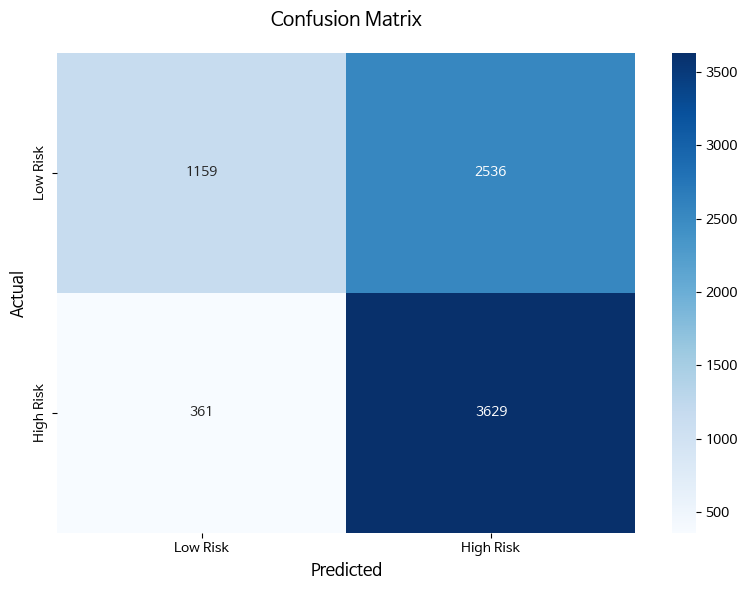

In [24]:
# Confusion Matrix ÏãúÍ∞ÅÌôî
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Low Risk', 'High Risk'],
    yticklabels=['Low Risk', 'High Risk'],
    ax=ax
)
ax.set_title('Confusion Matrix', fontsize=14, pad=20)
ax.set_xlabel('Predicted', fontsize=12)
ax.set_ylabel('Actual', fontsize=12)
plt.tight_layout()
plt.show()

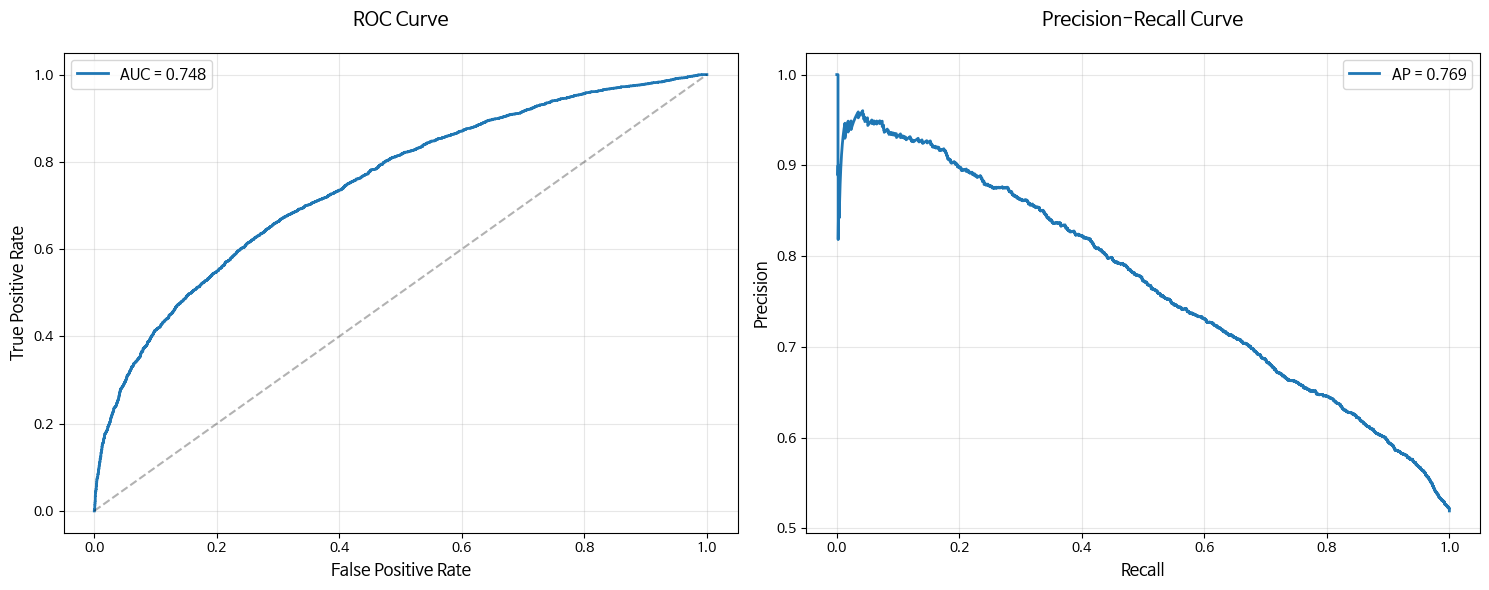

In [25]:
# ROC Curve & Precision-Recall Curve
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_proba[:, 1])
axes[0].plot(fpr, tpr, linewidth=2, label=f'AUC = {auc:.3f}')
axes[0].plot([0, 1], [0, 1], 'k--', alpha=0.3)
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('ROC Curve', fontsize=14, pad=20)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Precision-Recall Curve
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_proba[:, 1])
ap = average_precision_score(y_test, y_test_proba[:, 1])
axes[1].plot(recall_test, precision_test, linewidth=2, label=f'AP = {ap:.3f}')
axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].set_title('Precision-Recall Curve', fontsize=14, pad=20)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

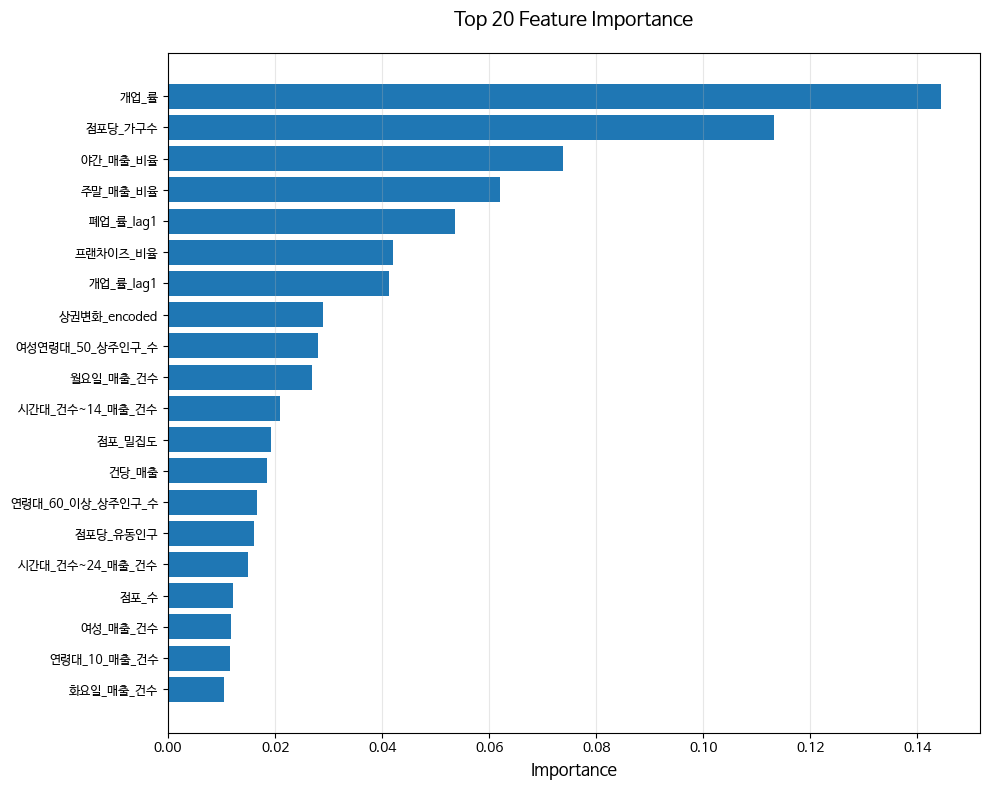


Top 20 Ï§ëÏöî Feature:
              feature  importance
2                Í∞úÏóÖ_Î•†    0.144476
149           Ï†êÌè¨Îãπ_Í∞ÄÍµ¨Ïàò    0.113263
143          ÏïºÍ∞Ñ_Îß§Ï∂ú_ÎπÑÏú®    0.073695
142          Ï£ºÎßê_Îß§Ï∂ú_ÎπÑÏú®    0.061948
138         ÌèêÏóÖ_Î•†_lag1    0.053632
153          ÌîÑÎûúÏ∞®Ïù¥Ï¶à_ÎπÑÏú®    0.042098
137         Í∞úÏóÖ_Î•†_lag1    0.041209
133      ÏÉÅÍ∂åÎ≥ÄÌôî_encoded    0.028971
107   Ïó¨ÏÑ±Ïó∞Î†πÎåÄ_50_ÏÉÅÏ£ºÏù∏Íµ¨_Ïàò    0.028036
28          ÏõîÏöîÏùº_Îß§Ï∂ú_Í±¥Ïàò    0.026807
37    ÏãúÍ∞ÑÎåÄ_Í±¥Ïàò~14_Îß§Ï∂ú_Í±¥Ïàò    0.020881
152            Ï†êÌè¨_Î∞ÄÏßëÎèÑ    0.019214
135             Í±¥Îãπ_Îß§Ï∂ú    0.018415
96   Ïó∞Î†πÎåÄ_60_Ïù¥ÏÉÅ_ÏÉÅÏ£ºÏù∏Íµ¨_Ïàò    0.016639
136          Ï†êÌè¨Îãπ_Ïú†ÎèôÏù∏Íµ¨    0.016033
40    ÏãúÍ∞ÑÎåÄ_Í±¥Ïàò~24_Îß§Ï∂ú_Í±¥Ïàò    0.014919
0                Ï†êÌè¨_Ïàò    0.012044
42           Ïó¨ÏÑ±_Îß§Ï∂ú_Í±¥Ïàò    0.011687
43       Ïó∞Î†πÎåÄ_10_Îß§Ï∂ú_Í±¥Ïàò    0.011552
29          ÌôîÏöîÏùº_Îß§Ï∂ú_Í±¥Ïàò    0.010376


In [26]:
# Feature Importance (Top 20)
feature_importances = model.feature_importances_
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': feature_importances
}).sort_values('importance', ascending=False).head(20)

fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(range(len(importance_df)), importance_df['importance'])
ax.set_yticks(range(len(importance_df)))
ax.set_yticklabels(importance_df['feature'], fontsize=9)
ax.invert_yaxis()
ax.set_xlabel('Importance', fontsize=12)
ax.set_title('Top 20 Feature Importance', fontsize=14, pad=20)
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\nTop 20 Ï§ëÏöî Feature:")
print(importance_df)

In [27]:
# # ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ÏóêÏÑú ÏÑ§Î™ÖÌïòÍ≥† Ïã∂ÏùÄ ÏÉòÌîå ÌïòÎÇòÎ•º ÏÑ†ÌÉù (Ïòà: Ï≤´ Î≤àÏß∏ Îç∞Ïù¥ÌÑ∞)
# sample_idx = 0
# X_sample = X_test_scaled[sample_idx].reshape(1, -1)
# y_sample_actual = y_test[sample_idx]
# y_sample_pred_prob = model.predict_proba(X_sample)[0, 1]

# print(f"ÏÉòÌîå {sample_idx}Î≤à Îç∞Ïù¥ÌÑ∞ Î∂ÑÏÑù")
# print(f"Ïã§Ï†ú Í∞í: {'High Risk' if y_sample_actual == 1 else 'Low Risk'}")
# print(f"ÏòàÏ∏° ÌôïÎ•† (High Risk): {y_sample_pred_prob:.4f}")

# # Î™®Îç∏Ïùò explain Í∏∞Îä•ÏúºÎ°ú Ïñ¥ÌÖêÏÖò ÎßàÏä§ÌÅ¨ Ï∂îÏ∂ú
# masks, _ = model.explain(X_sample)

# # ÎßàÏä§ÌÅ¨ ÏãúÍ∞ÅÌôî
# fig, ax = plt.subplots(figsize=(12, 8))
# im = ax.imshow(masks[0], cmap='viridis')
# ax.set_yticks(range(len(feature_cols)))
# ax.set_yticklabels(feature_cols, fontsize=8)
# ax.set_xlabel("Decision Steps")
# ax.set_ylabel("Features")
# ax.set_title(f"Feature Attentions for Sample {sample_idx}")
# fig.colorbar(im, ax=ax)
# plt.tight_layout()
# plt.show()

KeyError: 0

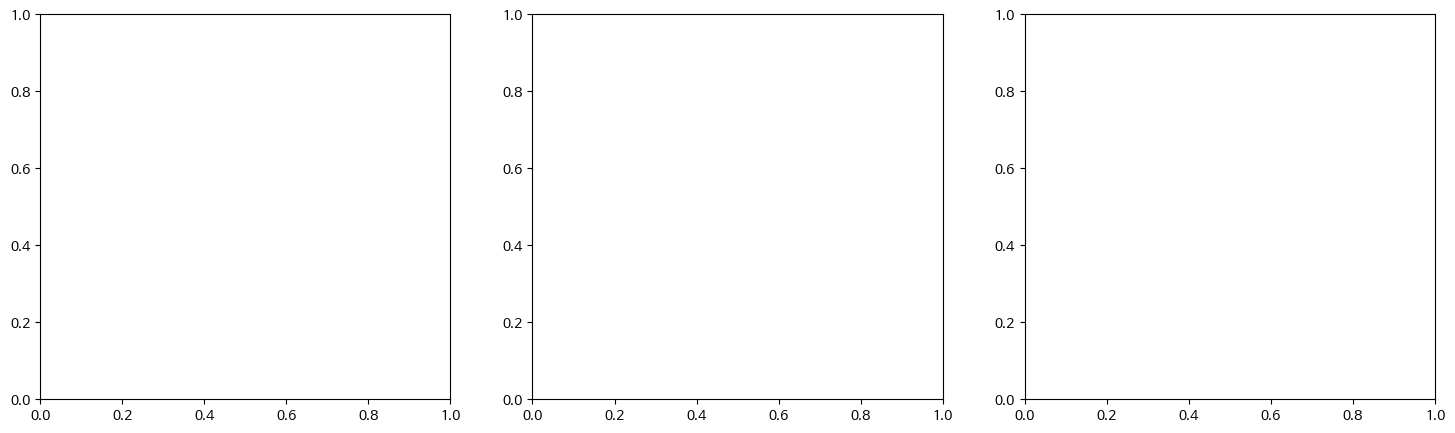

In [28]:
# Training History
history = model.history

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss
if 'loss' in history:
    axes[0].plot(history['loss'], label='Train Loss', linewidth=2)
if 'val_0_loss' in history:
    axes[0].plot(history['val_0_loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, pad=20)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Accuracy
if 'train_accuracy' in history:
    axes[1].plot(history['train_accuracy'], label='Train Accuracy', linewidth=2)
if 'val_0_accuracy' in history:
    axes[1].plot(history['val_0_accuracy'], label='Val Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Training and Validation Accuracy', fontsize=14, pad=20)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

# AUC
if 'train_auc' in history:
    axes[2].plot(history['train_auc'], label='Train AUC', linewidth=2)
if 'val_0_auc' in history:
    axes[2].plot(history['val_0_auc'], label='Val AUC', linewidth=2)
axes[2].set_xlabel('Epoch', fontsize=12)
axes[2].set_ylabel('AUC', fontsize=12)
axes[2].set_title('Training and Validation AUC', fontsize=14, pad=20)
axes[2].legend(fontsize=11)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 10. Î™®Îç∏ Ï†ÄÏû•

In [30]:
# Ï†ÄÏû• ÎîîÎ†âÌÜ†Î¶¨ ÏÉùÏÑ±
save_dir = Path('./saved_models')
save_dir.mkdir(exist_ok=True)

print("‚úì Î™®Îç∏ Î∞è Îç∞Ïù¥ÌÑ∞ Ï†ÄÏû•")

# Î™®Îç∏ Ï†ÄÏû•
model_path = save_dir / 'tabnet_closure_prediction.zip'
model.save_model(str(model_path))
print(f"  - Î™®Îç∏: {model_path}")

# Scaler Ï†ÄÏû•
scaler_path = save_dir / 'scaler.pkl'
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"  - Scaler: {scaler_path}")

# Label Encoders Ï†ÄÏû•
encoders = {
    'ÏûêÏπòÍµ¨': le_district,
    'ÏóÖÏ¢Ö': le_industry
}
encoders_path = save_dir / 'label_encoders.pkl'
with open(encoders_path, 'wb') as f:
    pickle.dump(encoders, f)
print(f"  - Label Encoders: {encoders_path}")

# Feature Ïù¥Î¶Ñ Ï†ÄÏû•
features_path = save_dir / 'feature_names.txt'
with open(features_path, 'w', encoding='utf-8') as f:
    for feat in feature_cols:
        f.write(f"{feat}\n")
print(f"  - Feature Names: {features_path}")

# ÌèâÍ∞Ä Í≤∞Í≥º Ï†ÄÏû•
results = {
    'optimal_threshold': float(optimal_threshold),
    'accuracy': float(accuracy),
    'precision': float(precision),
    'recall': float(recall),
    'f1': float(f1),
    'auc': float(auc),
    'confusion_matrix': cm.tolist(),
    'best_epoch': int(model.best_epoch),
    'best_loss': float(model.best_cost)
}

results_path = save_dir / 'results.json'
with open(results_path, 'w') as f:
    json.dump(results, f, indent=2)
print(f"  - Results: {results_path}")

# Feature Importance Ï†ÄÏû•
importance_path = save_dir / 'feature_importance.csv'
importance_df.to_csv(importance_path, index=False, encoding='utf-8-sig')
print(f"  - Feature Importance: {importance_path}")

‚úì Î™®Îç∏ Î∞è Îç∞Ïù¥ÌÑ∞ Ï†ÄÏû•
Successfully saved model at saved_models/tabnet_closure_prediction.zip.zip
  - Î™®Îç∏: saved_models/tabnet_closure_prediction.zip
  - Scaler: saved_models/scaler.pkl
  - Label Encoders: saved_models/label_encoders.pkl
  - Feature Names: saved_models/feature_names.txt
  - Results: saved_models/results.json
  - Feature Importance: saved_models/feature_importance.csv


## üìä ÏµúÏ¢Ö Í≤∞Í≥º ÏöîÏïΩ

In [29]:
print("\n" + "="*80)
print(" " * 30 + "ÏµúÏ¢Ö Í≤∞Í≥º ÏöîÏïΩ")
print("="*80)

print(f"\n‚úì Î™®Îç∏: TabNet ÌèêÏóÖÎ•† Î∂ÑÎ•ò ÏòàÏ∏°")
print(f"‚úì ÎîîÎ∞îÏù¥Ïä§: {device}")
print(f"‚úì ÏµúÏ†Å Threshold: {optimal_threshold:.4f}")
print(f"‚úì Best Epoch: {model.best_epoch}")

print(f"\n‚úì Test Set ÏÑ±Îä•:")
print(f"  - Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"  - Precision: {precision:.4f} ({precision*100:.2f}%)")
print(f"  - Recall:    {recall:.4f} ({recall*100:.2f}%)")
print(f"  - F1 Score:  {f1:.4f}")
print(f"  - AUC:       {auc:.4f}")

print(f"\n‚úì Ï†ÄÏû•Îêú ÌååÏùº:")
print(f"  - Î™®Îç∏: {save_dir}/tabnet_closure_prediction.zip")
print(f"  - Scaler: {save_dir}/scaler.pkl")
print(f"  - Encoders: {save_dir}/label_encoders.pkl")
print(f"  - Features: {save_dir}/feature_names.txt")
print(f"  - Results: {save_dir}/results.json")
print(f"  - Importance: {save_dir}/feature_importance.csv")

print("\n" + "üéâ "*20)
print(" "*30 + "ÏôÑÎ£å!")
print("üéâ "*20 + "\n")


                              ÏµúÏ¢Ö Í≤∞Í≥º ÏöîÏïΩ

‚úì Î™®Îç∏: TabNet ÌèêÏóÖÎ•† Î∂ÑÎ•ò ÏòàÏ∏°
‚úì ÎîîÎ∞îÏù¥Ïä§: cuda
‚úì ÏµúÏ†Å Threshold: 0.3304
‚úì Best Epoch: 74

‚úì Test Set ÏÑ±Îä•:
  - Accuracy:  0.6230 (62.30%)
  - Precision: 0.5886 (58.86%)
  - Recall:    0.9095 (90.95%)
  - F1 Score:  0.7147
  - AUC:       0.7484

‚úì Ï†ÄÏû•Îêú ÌååÏùº:


NameError: name 'save_dir' is not defined